# Monte Carlo Case Study for Validus. Harry Cohen

In the next cell, we calculate the 1000 different monte carlo paths for the GBPUSD spot rate over five years. We use a month as the time step for the markov process (this can be easily changed by altering **T**). 

For each monte carlo path, we execute a random walk on the spot rate using normally distributed random variables multiplied by the volatility. We use the Geometric Brownian Motion update $ S_{t+1} = S_t + S_t \times \sigma \times \epsilon$ where $S_t$ is the spot rate at time $t$, $\sigma$ is the volatility and $\epsilon$ is a random normal variable. There is no drift term as the drift is taken to be zero.

The results is a list of spot rates called **allspots**. Each sublist of **allspots** represents the five spot rates for each year for every monte carlo path.

In [78]:
import numpy as np
import matplotlib.pyplot as plt
import numpy_financial as npf



sigma = 0.1228                                             #Volatility.
T = 60                                                     #Time periods (60 for months, 1826/1825 for days).
t = T/5                                                    #Number of time periods per year.
iters = 1000                                               #Number of Monte Carlo paths.
allspots = [0 for i in range(iters)]
for j in range(iters):
    normals = np.random.normal(0, 1, T)                    #Generate random normal variables over all time steps.
    spot = 1.2401                                          #Initial spot rate.
    spots = [0 for i in range(5)]
    for i in range(T):
        '''if spot + spot*normals[i]*sigma*(1/(t**0.5)) < 0:  #Do not allow negative spot rates.
            pass
        else:
            spot += spot*normals[i]*sigma*(1/(t**0.5))        #GBM update.'''
        spot += spot*normals[i]*sigma*(1/(t**0.5))         #GBM update.
        if (i+1)%t == 0:                                       #Save the simulated spot rate for each year.
            spots[int(i/t)] = spot
    allspots[j] = spots                                    #Store the five yearly spot rates for each simulation/path.
    


In the cell below, we calculate the value of the cash flows at each year for every monte carlo path. This is done by converting the future cash flows into USD using the simulated future spot rates. We also represent this at each year in five histograms.

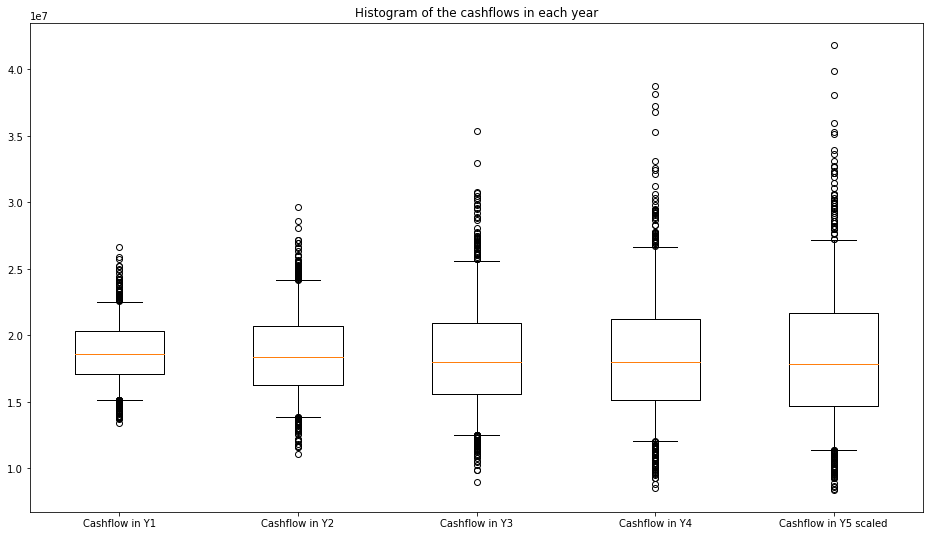

In [79]:
initialGBP = [15000000, 15000000, 15000000, 15000000, 100000000]              #Inital cash flows in GBP.
initialUSD = [i*1.2401 for i in initialGBP]                                   #Initial cash flows in USD.

path_sUSD = [0 for i in range(iters)]
for i in range(iters):                                                        #Loop over each simulation.
    pathUSD = [initialGBP[j]*allspots[i][j] for j in range(len(initialGBP))]  #Convert future cash flows to USD using
    path_sUSD[i] = pathUSD                                                       #the simulated future spot rates.


track21 = [0 for i in range(iters)]    
track22 = [0 for i in range(iters)]    
track23 = [0 for i in range(iters)]    
track24 = [0 for i in range(iters)]    
track25 = [0 for i in range(iters)]
for j in range(len(allspots)):
    track21[j] = path_sUSD[j][0]                                              #Cashflows 30/06/21.
    track22[j] = path_sUSD[j][1]                                              #Cashflows 30/06/22.
    track23[j] = path_sUSD[j][2]                                              #Cashflows 30/06/23.
    track24[j] = path_sUSD[j][3]                                              #Cashflows 30/06/24.
    track25[j] = path_sUSD[j][4]                                              #Cashflows 30/06/25.


    
cash_flows_dict = {'Cashflow in Y1': track21, 'Cashflow in Y2': track22, 'Cashflow in Y3': track23, 'Cashflow in Y4':\
           track24, 'Cashflow in Y5 scaled': [i*15/100 for i in track25]}

#Note that we scale the cashflow in Y5 to so we can compare with previous years.


fig, ax = plt.subplots(figsize = (16, 9))
ax.boxplot(cash_flows_dict.values(), whis = [5, 95])                          #Whiskers at 5th and 95th percentiles.
plt.title('Histogram of the cashflows in each year')
ax.set_xticklabels(cash_flows_dict.keys())


plt.plot()
plt.show()



We see that as time increases, the range of the converted simulated cash flows increase. This makes sense as there is are more update steps for the volatility to change as the spot rates as time increases.

Additionaly, we have a positive skew. This is due to the dependency of the GBM model's update at time $t$ on the previous result at $t-1$. As, at each step, we multiply the update by the previous spot rate, if the previous spot rate is small (below 1) we are unlikely to increase/decrease much during the update and so the spot rate will remain small. If the previous spot step is large, however, we can increase (and decrease) greatly during the update and this results in a compounding effect.

In the cell below, we calculate the IRR for each monte carlo path and then plot the distribution on a histogram and a boxplot. Additionally, we give the 5th, 50th and 95th percentiles, aswell as the minimum and maximum IRR.

The 50th percentile is 12.12%
The 95th percentile is 22.27%
The 5th percentile is 1.91%
The minimum is -4.05%
The maximum is 32.41%


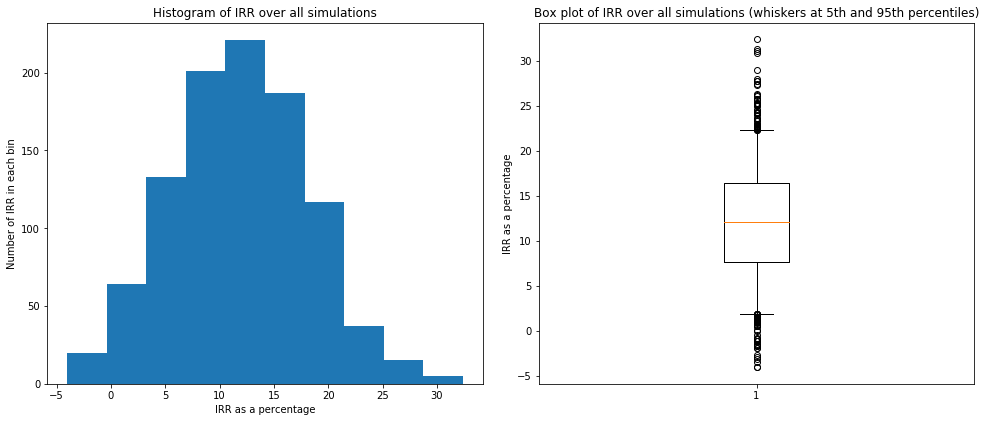

In [80]:
trackirr = [0 for i in range(iters)]
for i in range(iters):
    trackirr[i] = npf.irr(np.concatenate([np.array([-100000000*1.2401]), np.array(path_sUSD[i])]))
    #Here we added the inital cashflow to each simulated path and then calculated the IRR for each path.

    
    
trackirr.sort()                                                                   #Sort the IRRs by size.
print('The 50th percentile is {0:.2f}%'.format(trackirr[int(0.5*iters)-1]*100))   #Get 5th percentile.
print('The 95th percentile is {0:.2f}%'.format(trackirr[int(0.95*iters)-1]*100))  #Get 95th percentile.
print('The 5th percentile is {0:.2f}%'.format(trackirr[int(0.05*iters)-1]*100))   #Get 50th percentile.
print('The minimum is {0:.2f}%'.format(trackirr[0]*100))                          #Get minimum IRR.
print('The maximum is {0:.2f}%'.format(trackirr[-1]*100))                         #Get maximum IRR.



fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
fig.tight_layout(pad = 2.5)

plt.subplot(1, 2, 1)
plt.title('Histogram of IRR over all simulations')
plt.xlabel('IRR as a percentage')
plt.ylabel('Number of IRR in each bin')
plt.hist([i*100 for i in trackirr])

plt.subplot(1, 2, 2)
plt.title('Box plot of IRR over all simulations (whiskers at 5th and 95th percentiles)')
plt.ylabel('IRR as a percentage')
plt.boxplot([i*100 for i in trackirr], whis = [5, 95])

plt.plot()
plt.show()

